#### Import Libraries

In [1]:
import numpy as np
import cv2
import pandas as pd
from PIL import Image
import os
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.measure import block_reduce
import sklearn.model_selection
import sklearn.ensemble
import sklearn.preprocessing
from scipy.ndimage import rotate

#### Load Training data and Test data

In [2]:
data = {'gt':[], 'nt':[], 'mt':[], 'pt':[]}
test = {'gt':[], 'nt':[], 'mt':[], 'pt':[]}
KEY = ['gt', 'nt', 'mt', 'pt']
np.random.seed(42)

def im_to_arr(dfl:list, path:str):
    filenames = os.listdir(path=path)
    filen = len(filenames)
    for i in range(filen):
        img = Image.open(path+'/'+filenames[i]).convert('L')
        dfl.append([np.asarray(img), img])

In [3]:
im_to_arr(data['gt'], "tumor_dataset/Training/glioma_tumor")
im_to_arr(data['nt'], "tumor_dataset/Training/no_tumor")
im_to_arr(data['mt'], "tumor_dataset/Training/meningioma_tumor")
im_to_arr(data['pt'], "tumor_dataset/Training/pituitary_tumor")
im_to_arr(test['gt'], "tumor_dataset/Testing/glioma_tumor")
im_to_arr(test['nt'], "tumor_dataset/Testing/no_tumor")
im_to_arr(test['mt'], "tumor_dataset/Testing/meningioma_tumor")
im_to_arr(test['pt'], "tumor_dataset/Testing/pituitary_tumor")

#### Data Augmentation, Deleting Background

In [4]:
def delete_bg(imgarr:np.ndarray, img:Image) -> list:
    ''' return `True` if img is 512x512 for third value. '''
    margin = [[-1,-1],[-1,-1]]
    wh = img.size
    for i in range(2):
        max_col = imgarr.max(axis=i)
        arr = max_col >= 40; streak = [0,0]; ssp = [-1,-1]; flag = 0
        for j in range(wh[i]):
            if flag == 2: break
            if margin[i][0] == -1:
                if arr[j]:
                    streak[0] += 1
                    if ssp[0] == -1: ssp[0] = j
                    if streak[0] >= wh[i]//7:
                        margin[i][0] = ssp[0]; flag += 1
                else: streak[0] = 0; ssp[0] = -1
            if margin[i][1] == -1:
                if arr[-j-1]:
                    streak[1] += 1
                    if ssp[1] == -1: ssp[1] = wh[i]-j
                    if streak[1] >= wh[i]//7:
                        margin[i][1] = ssp[1]; flag += 1
                else: streak[1] = 0; ssp[1] = -1
    timg = img.crop((margin[0][0],margin[1][0],margin[0][1],margin[1][1])).resize((512,512))
    timgarr = np.asarray(timg)
    
    return [timgarr, timg, wh[0] == 512 and wh[1] == 512]

In [5]:
for k in KEY:
    length = len(data[k]); test_length = len(test[k])
    for i in range(length):
        data[k][i] = delete_bg(data[k][i][0], data[k][i][1])
    for i in range(test_length):
        test[k][i] = delete_bg(test[k][i][0], test[k][i][1])
    for i in range(length):
        ang = (1 if np.random.randint(0,2) else -1) * (np.random.random() * 3 + 3)
        rotated = rotate(data[k][i][0], angle=ang, axes=(1, 0), reshape=False, mode='constant', cval=0)
        data[k].append([rotated, -1, data[k][i][2]])
    for i in range(length*2):
        shift_x = (1 if np.random.randint(0,2) else -1) * np.random.randint(8, 17)
        shift_y = (1 if np.random.randint(0,2) else -1) * np.random.randint(8, 17)
        moved = np.roll(data[k][i][0], (shift_x, shift_y), axis=(1, 0))
        if shift_x > 0:
            moved[:, :shift_x] = 0
        elif shift_x < 0:
            moved[:, shift_x:] = 0
        if shift_y > 0:
            moved[:shift_y, :] = 0
        elif shift_y < 0:
            moved[shift_y:, :] = 0
        data[k].append([moved, -1, data[k][i][2]])


#### Pooling, Histogram Equalization, PCA Dimension Reduction

In [6]:
pool_func = lambda x, axis: np.uint8(np.round(np.average(x, axis=axis)))

0.755632173498644


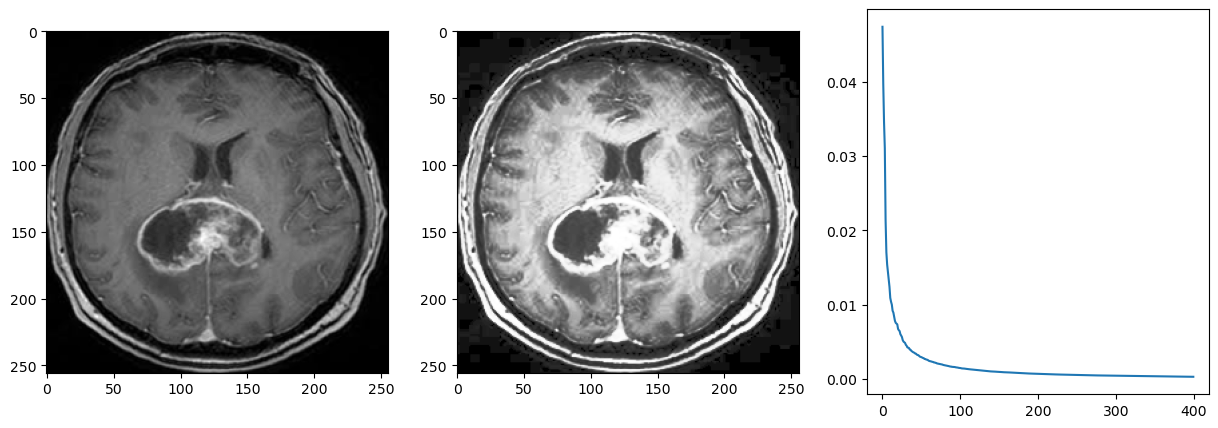

In [7]:
fig, axes = plt.subplots(1,3); fig.set_size_inches(15,5)
train_pooled = []; train_label_all = []; i = 0; kpool = 2; output = []; test_pooled = []; y_test = []
for k in KEY:
    length = len(data[k]); test_length = len(test[k])
    train_pooled += [block_reduce(data[k][i][0], (kpool, kpool), pool_func) for i in range(length)]
    test_pooled += [block_reduce(test[k][i][0], (kpool, kpool), pool_func) for i in range(test_length)]
    train_label_all += [i for _ in range(length)]
    y_test += [i for _ in range(test_length)]
    i += 1

data_all = train_pooled + test_pooled
axes[0].imshow(data_all[-368], cmap='gray')
for i in range(len(data_all)):
    data_all[i] = cv2.equalizeHist(data_all[i]).reshape((512//kpool) ** 2)
axes[1].imshow(data_all[-368].reshape((512//kpool), (512//kpool)), cmap='gray')

pca = sklearn.decomposition.PCA(n_components=400)
pca.fit(data_all[:len(train_pooled)])
print(np.sum(pca.explained_variance_ratio_))
axes[2].plot(pca.explained_variance_ratio_)
transformed_data_all = pca.transform(data_all)
train_data_all = transformed_data_all[:len(train_pooled)]
X_test = transformed_data_all[len(train_pooled):]

#### Model

In [8]:
seed = 36459 # np.random.randint(0, 100000)
X_train, y_train = train_data_all, train_label_all

model1 = sklearn.ensemble.ExtraTreesClassifier(n_estimators=100, criterion='log_loss', max_features='log2', random_state=seed)
model2 = sklearn.ensemble.RandomForestClassifier(n_estimators=100, criterion='log_loss', max_features='sqrt', random_state=seed)

model = sklearn.ensemble.VotingClassifier([("M1", model1), ("M2", model2)], voting="soft", weights=[.5,.5])
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test); accuracy = sklearn.metrics.accuracy_score(y_test_pred, y_test)

In [9]:
print(accuracy)

0.8299492385786802
